In [2]:
# load libraries
import google.datalab.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

## Count Total FTE Observations From Q1 2000 to Q2 2014

In [113]:
%%bq query

SELECT COUNT(EMP_ID) as count_obs, NSFTP_IND
FROM `processed_data.status`
GROUP BY NSFTP_IND

count_obs,NSFTP_IND
14548158,2
95749245,1


### There are almost 96 million observations (employee-quarter) with NSFTP = 1 (non-seasonal full time employees)

In [114]:
%%bq query

SELECT COUNT(DISTINCT EMP_ID) as count_obs, NSFTP_IND
FROM `processed_data.status`
GROUP BY NSFTP_IND

count_obs,NSFTP_IND
1748165,2
3264838,1


### There are 3.3 million unique employees with NSFTP = 1 Since Q1 2000

# Count employees by agency, not including seasonal positions 

In [232]:
# Count employees by agency, filter out seasonal employees (e.g. only include nsftp_ind = '1')
count_emp_fte = bq.Query('SELECT FILE_DT AS date, \
                                 agency, \
                                 nsftp_ind, \
                                 COUNT(EMP_ID) AS countemp, \
                                 COUNT(DISTINCT EMP_ID) as countdistinct \
                        FROM `processed_data.status` \
                        WHERE nsftp_ind = "1" \
                        GROUP BY date, agency, nsftp_ind \
                        ORDER BY date ASC, agency ASC')
count_emp_fte = count_emp_fte.execute(output_options=bq.QueryOutput.dataframe()).result()
print count_emp_fte.head()

         date agency nsftp_ind  countemp  countdistinct
0  2000-03-31   AB00         1        26             26
1  2000-03-31   AF**         1        11             11
2  2000-03-31   AF02         1        22             22
3  2000-03-31   AF03         1       184            184
4  2000-03-31   AF04         1         1              1


In [233]:
count_emp_fte['date'] = count_emp_fte['date'].astype('datetime64[ns]')
print count_emp_fte.dtypes

date             datetime64[ns]
agency                   object
nsftp_ind                object
countemp                  int64
countdistinct             int64
dtype: object


In [234]:
# Convert date to quarter (for better graphing)
count_emp_fte['year'] = count_emp_fte['date'].dt.year
count_emp_fte['quarter'] = count_emp_fte['date'].dt.quarter
count_emp_fte['period'] = count_emp_fte['year'].astype(str) +'-Q'+ count_emp_fte['quarter'].astype(str)
print count_emp_fte.head()

        date agency nsftp_ind  countemp  countdistinct  year  quarter   period
0 2000-03-31   AB00         1        26             26  2000        1  2000-Q1
1 2000-03-31   AF**         1        11             11  2000        1  2000-Q1
2 2000-03-31   AF02         1        22             22  2000        1  2000-Q1
3 2000-03-31   AF03         1       184            184  2000        1  2000-Q1
4 2000-03-31   AF04         1         1              1  2000        1  2000-Q1


In [57]:
# Sum to get all FTE employees by quarter
count_emp_fte.groupby('period').head().head()

,date,agency,nsftp_ind,countemp,countdistinct,year,quarter,period
0,2000-03-31,AB00,1,26,26,2000,1,2000-Q1
1,2000-03-31,AF**,1,11,11,2000,1,2000-Q1
2,2000-03-31,AF02,1,22,22,2000,1,2000-Q1
3,2000-03-31,AF03,1,184,184,2000,1,2000-Q1
4,2000-03-31,AF04,1,1,1,2000,1,2000-Q1


In [39]:
# Get count of all employees by quarter
total_count_emp_fte = bq.Query('SELECT CAST(FILE_DT AS string) AS date, \
                             nsftp_ind, \
                             COUNT(EMP_ID) AS countemp, \
                             COUNT(DISTINCT EMP_ID) as countdistinct \
                        FROM `processed_data.status` \
                        WHERE nsftp_ind = "1" \
                        GROUP BY date, nsftp_ind \
                        ORDER BY date ASC')
total_count_emp_fte = total_count_emp_fte.execute(output_options=bq.QueryOutput.dataframe()).result()

# convert data types
total_count_emp_fte['date'] = total_count_emp_fte['date'].astype('datetime64[ns]')

# Create column for distinct employees: total observations
total_count_emp_fte['perc_distinct'] = total_count_emp_fte['countdistinct'].astype(float)/total_count_emp_fte['countemp']

# Convert date to quarter (for better graphing)
total_count_emp_fte['year'] = total_count_emp_fte['date'].dt.year
total_count_emp_fte['quarter'] = total_count_emp_fte['date'].dt.quarter
total_count_emp_fte['period'] = total_count_emp_fte['year'].astype(str) +'-Q'+ total_count_emp_fte['quarter'].astype(str)
print total_count_emp_fte.head()

        date nsftp_ind  countemp  countdistinct  perc_distinct  year  quarter  \
0 2000-03-31         1   1517026        1514981       0.998652  2000        1   
1 2000-06-30         1   1516815        1514862       0.998712  2000        2   
2 2000-09-30         1   1518131        1515939       0.998556  2000        3   
3 2000-12-13         1   1518240        1516179       0.998643  2000        4   
4 2001-03-31         1   1515770        1513893       0.998762  2001        1   

    period  
0  2000-Q1  
1  2000-Q2  
2  2000-Q3  
3  2000-Q4  
4  2001-Q1  


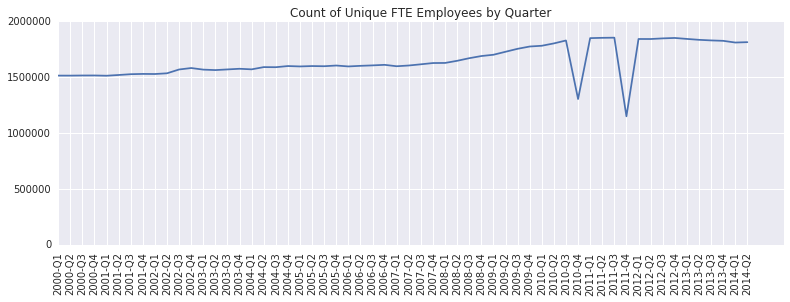

In [50]:
# Plot number of employees
fig = plt.figure(figsize=(13, 4))
x = list(range(0, len(total_count_emp_fte)))
xticks = list(total_count_emp_fte.period)
# plt.plot(list(total_count_emp.countemp))
plt.plot(list(total_count_emp_fte.countdistinct))
plt.xticks(x, xticks, rotation = 'vertical')
plt.ylim((0, 2000000))
plt.title("Count of Unique FTE Employees by Quarter")
plt.show()

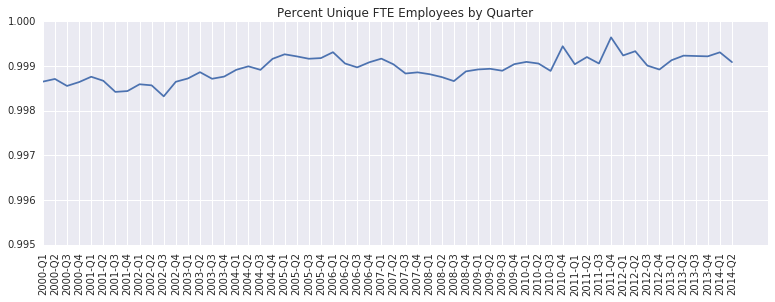

In [56]:
# Plot Percent of Distinct Employees
# Much more stable and higher than with seasonal employees included 

fig = plt.figure(figsize=(13, 4))
x = list(range(0, len(total_count_emp_fte)))
xticks = list(total_count_emp_fte.period)
plt.plot(list(total_count_emp_fte.perc_distinct))
plt.xticks(x, xticks, rotation = 'vertical')
plt.ylim((0.995, 1))
plt.title("Percent Unique FTE Employees by Quarter")
plt.show()

## Top 20 Agencies in Q2 2014 by FTE

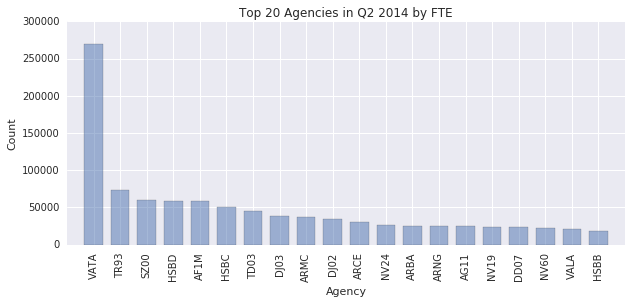

['VATA', 'TR93', 'SZ00', 'HSBD', 'AF1M', 'HSBC', 'TD03', 'DJ03', 'ARMC', 'DJ02', 'ARCE', 'NV24', 'ARBA', 'ARNG', 'AG11', 'NV19', 'DD07', 'NV60', 'VALA', 'HSBB']


In [236]:
# 20 largest agencies (by FTE) as of Q2 2014
top_20_agency = count_emp_fte.loc[count_emp_fte['period'] == '2014-Q2'].sort_values('countdistinct', ascending=False).head(20)

fig = plt.figure(figsize=(10, 4))
objects = list(top_20_agency.agency)
y_pos = np.arange(len(top_20_agency))
countfte = list(top_20_agency.countdistinct)
 
plt.bar(y_pos, countfte, alpha=0.5, width=0.7, align="center")
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.ylabel('Count')
plt.xlabel('Agency')
plt.xlim((-1, 20))
plt.title('Top 20 Agencies in Q2 2014 by FTE')
 
plt.show()
print objects
top_agencies = objects

## Count FTE Over Time for Top 20 Agencies

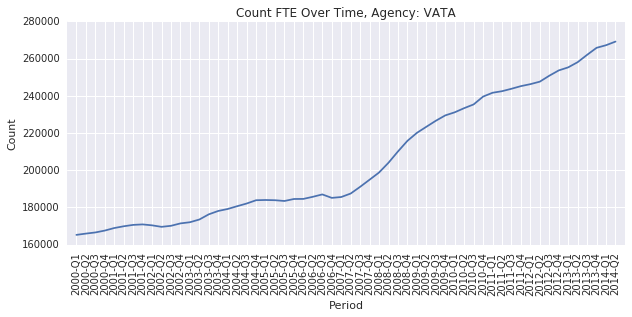

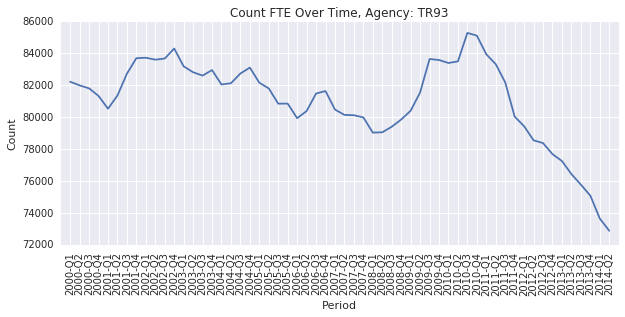

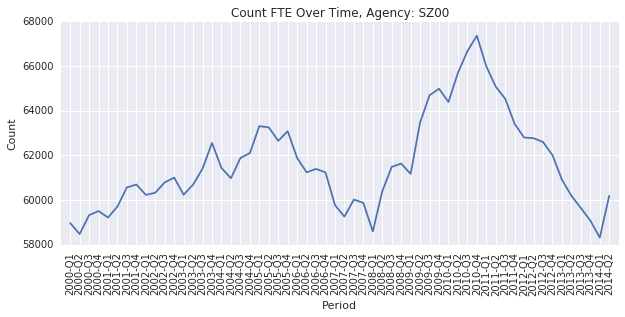

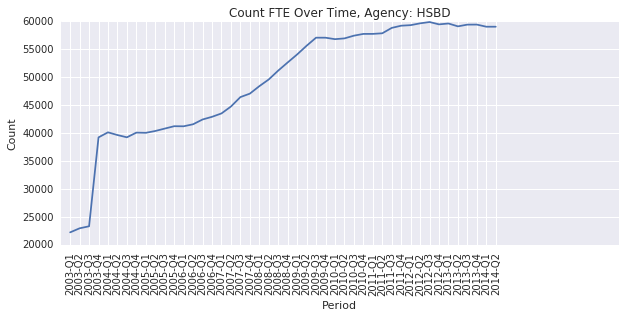

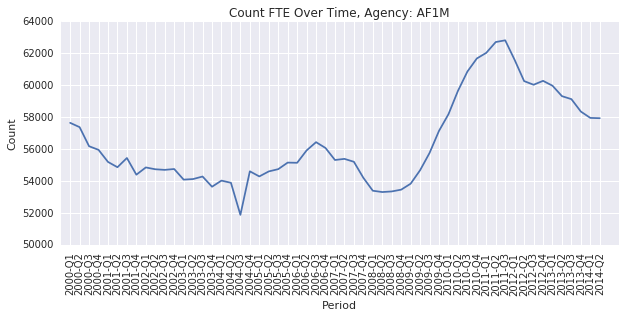

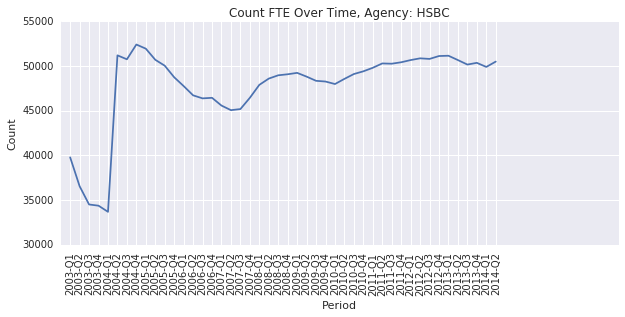

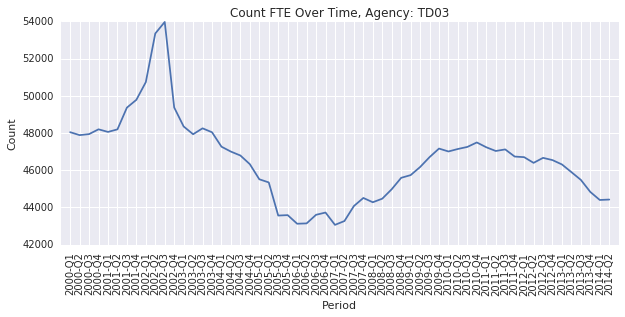

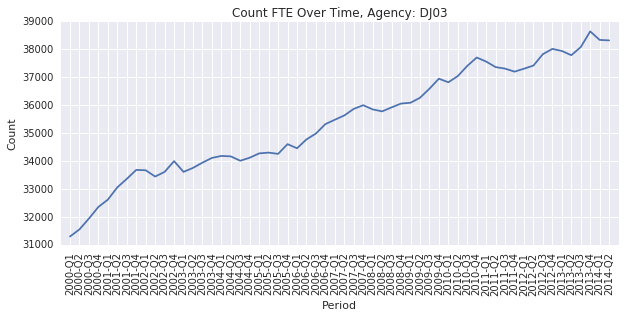

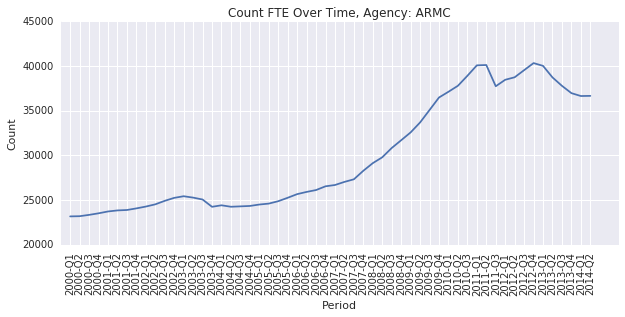

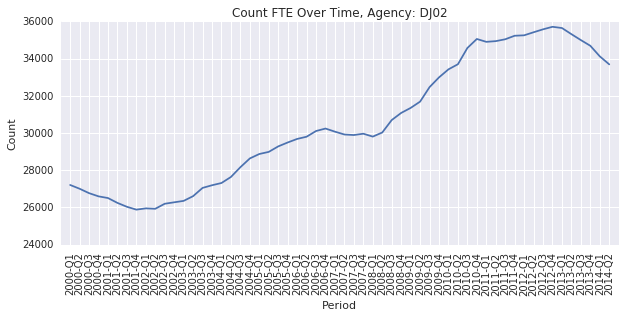

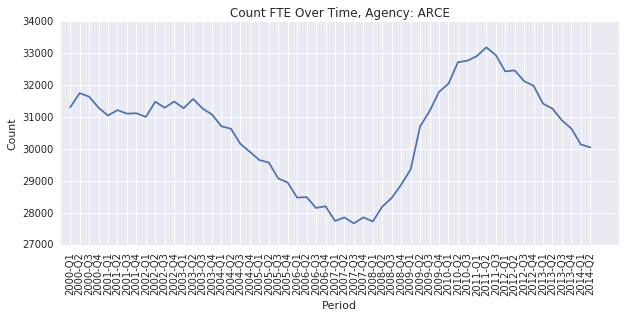

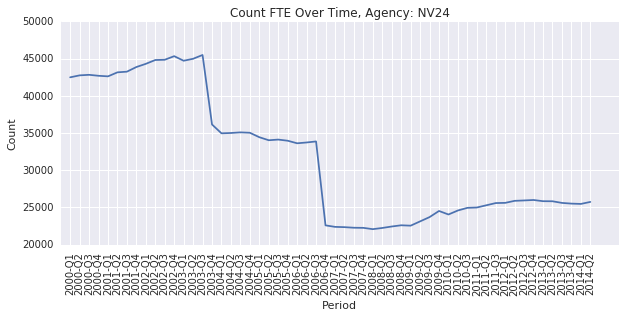

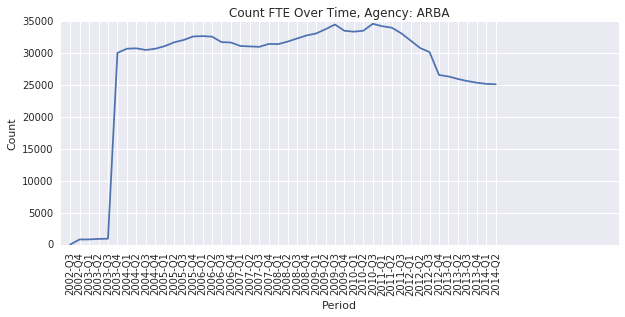

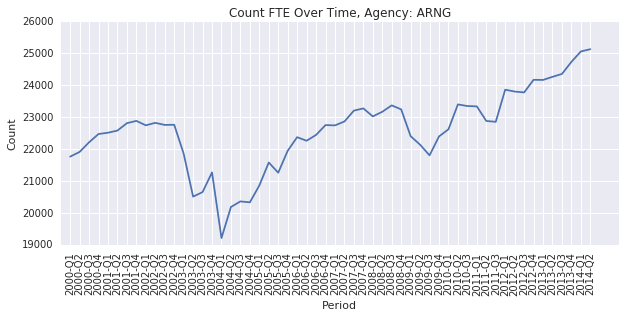

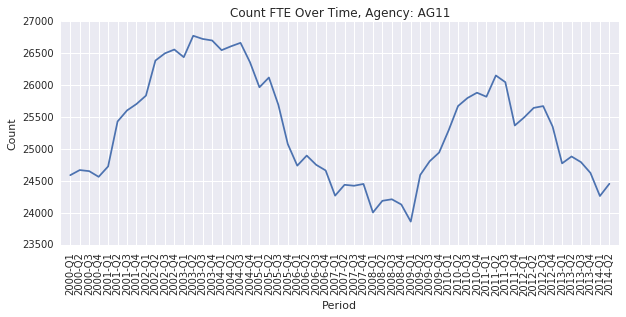

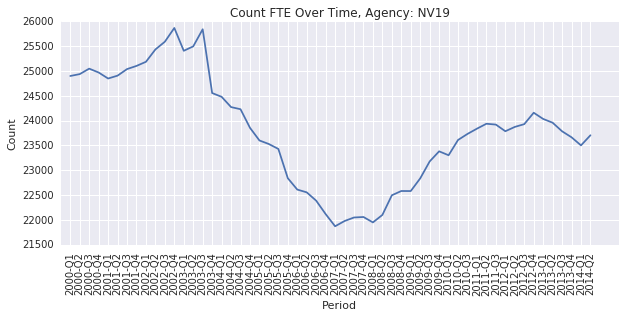

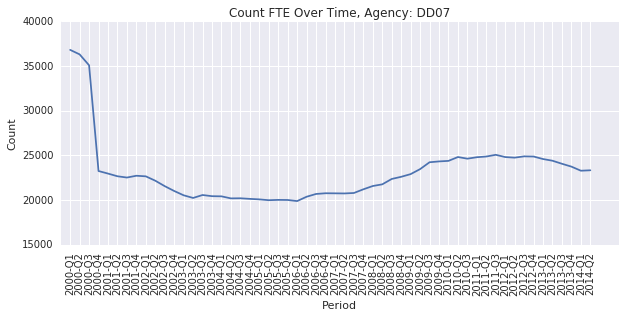

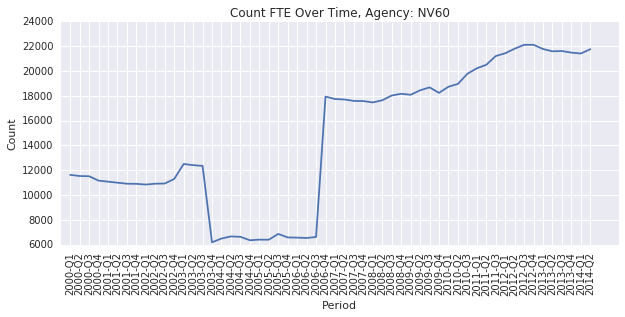

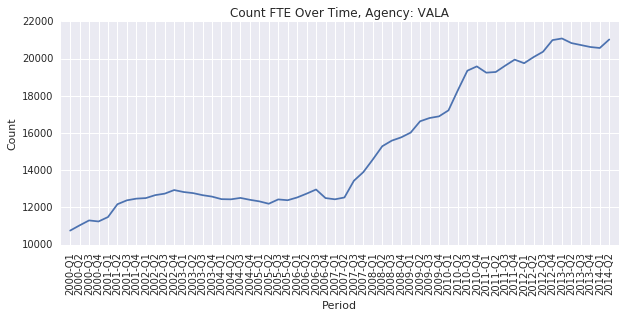

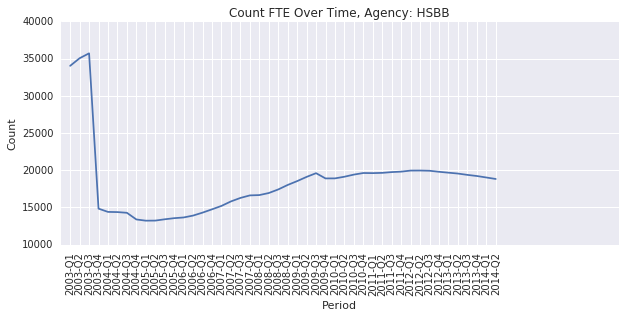

In [267]:
# Count FTE for Top 20 Agencies
# Sample chart (rest will be in Tableau?)
def count_fte_agency(df, agency):
  count_fte_agency = df.loc[df['agency'] == agency].sort_values('period')
  fig = plt.figure(figsize=(10, 4))
  objects = list(count_fte_agency.period)
  y_pos = np.arange(len(count_fte_agency))
  countfte = list(count_fte_agency.countdistinct)

  plt.plot(countfte)
  plt.xlim((-1, 58))
  plt.xticks(y_pos, objects, rotation = 'vertical')
  plt.ylabel('Count')
  plt.xlabel('Period')
  plt.title('Count FTE Over Time, Agency: ' + str(agency))

  plt.show()

for agency in top_agencies:
  count_fte_agency(count_emp_fte, agency)

# Duty Station (location), FTE Only

In [181]:
# Count of employees by Duty Station and Period, FTE only

station_fte = bq.Query('SELECT duty_station, FILE_DT as date, COUNT(EMP_ID) as countemp, COUNT(DISTINCT EMP_ID) as countdistinct, NSFTP_IND \
                    FROM `processed_data.status` \
                    WHERE NSFTP_IND = "1" \
                    GROUP BY FILE_DT, NSFTP_IND, duty_station \
                    ORDER BY FILE_DT ASC, duty_station')
station_fte = station_fte.execute(output_options=bq.QueryOutput.dataframe()).result()

# Convert date to datetime format
station_fte['date'] = station_fte['date'].astype('datetime64[ns]')

# Convert date to quarter (for better graphing)
station_fte['year'] = station_fte['date'].dt.year
station_fte['quarter'] = station_fte['date'].dt.quarter
station_fte['period'] = station_fte['year'].astype(str) +'-Q'+ station_fte['quarter'].astype(str)

print station_fte.head()
print station_fte.dtypes

  duty_station       date  countemp  countdistinct NSFTP_IND  year  quarter  \
0    ######### 2000-03-31    871967         870036         1  2000        1   
1    ********* 2000-03-31       872            872         1  2000        1   
2    010000025 2000-03-31         1              1         1  2000        1   
3    010000101 2000-03-31         1              1         1  2000        1   
4    010010067 2000-03-31         4              4         1  2000        1   

    period  
0  2000-Q1  
1  2000-Q1  
2  2000-Q1  
3  2000-Q1  
4  2000-Q1  
duty_station             object
date             datetime64[ns]
countemp                  int64
countdistinct             int64
NSFTP_IND                object
year                      int64
quarter                   int64
period                   object
dtype: object


In [187]:
# Number of stations
print 'Number of Stations:', len(station_fte.duty_station.unique())
print 'Sample Station Names:', list(station_fte.duty_station[:10])

Number of Stations: 10487
Sample Station Names: ['#########', '*********', '010000025', '010000101', '010010067', '010047117', '010050095', '010060123', '010080055', '010090039']


### There are 10,487 stations! Group by State?

## Top 20 Stations as of Q2 2014, FTE Only

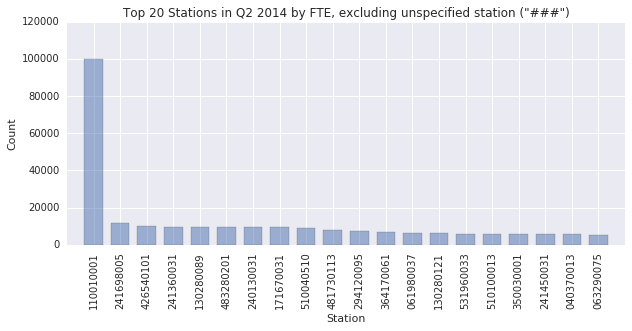

['110010001', '241698005', '426540101', '241360031', '130280089', '483280201', '240130031', '171670031', '510040510', '481730113', '294120095', '364170061', '061980037', '130280121', '531960033', '510100013', '350030001', '241450031', '040370013', '063290075']


In [246]:
# Most populous stations by Unique FTE as of Q2 2014, excluding ### and ***
top_20_station = station_fte.loc[station_fte['period'] == '2014-Q2'].sort_values('countdistinct', ascending=False).head(21)

fig = plt.figure(figsize=(10, 4))
objects = list(top_20_station.duty_station[1:])
y_pos = np.arange(len(top_20_station[1:]))
countfte = list(top_20_station.countdistinct[1:])
 
plt.bar(y_pos, countfte, alpha=0.5, width=0.7, align="center")
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.ylabel('Count')
plt.xlabel('Station')
plt.xlim((-1, 20))
plt.title('Top 20 Stations in Q2 2014 by FTE, excluding unspecified station ("###")')
 
plt.show()
print objects
top_stations = objects

In [275]:
# Count of Unspecified Stations (### and ***) 
print station_fte.loc[station_fte['period'] == '2014-Q2'].loc[station_fte['duty_station'] == '#########'].iloc[:1, :4]
print station_fte.loc[station_fte['period'] == '2014-Q2'].loc[station_fte['duty_station'] == '*********'].iloc[:1, :4]

# Percenage of counts to total (distinct only)
totaldistinct = sum(station_fte.loc[station_fte['period'] == '2014-Q2'].countdistinct)
distinct_unsp1 = station_fte.loc[station_fte['period'] == '2014-Q2'].loc[station_fte['duty_station'] == '#########'].countdistinct.iloc[0]
distinct_unsp2 = station_fte.loc[station_fte['period'] == '2014-Q2'].loc[station_fte['duty_station'] == '*********'].countdistinct.iloc[0]
print 'total distinct: ', totaldistinct
print 'Percent(%) ### station: ', distinct_unsp1/float(totaldistinct)*100
print 'Percent(%) *** station: ', distinct_unsp2/float(totaldistinct)*100

       duty_station       date  countemp  countdistinct
414941    ######### 2014-06-30   1026256        1024879
       duty_station       date  countemp  countdistinct
414942    ********* 2014-06-30      1056           1056
total distinct:  1814790
Percent(%) ### station:  56.4736966812
Percent(%) *** station:  0.0581885507414


### About 56% of Q2 2014 employees have unspecified locations. No employees are missing station information. Might be DOD? 

In [179]:
np.where(pd.isnull(station_fte.duty_station))

(array([], dtype=int64),)

## Count employees for top 20 stations over time

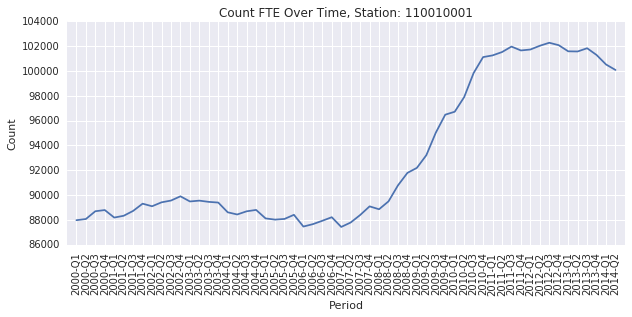

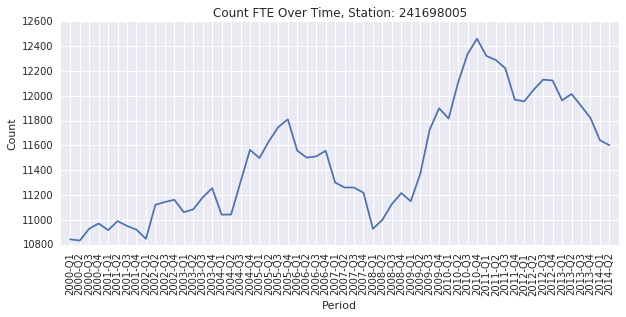

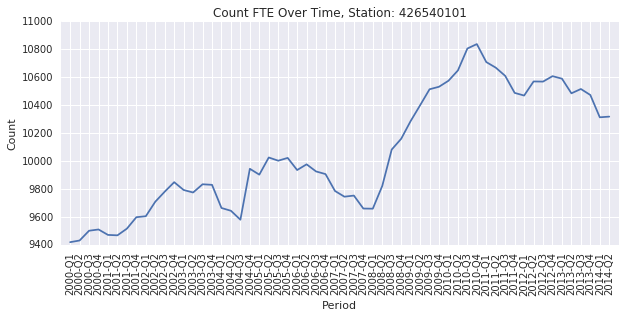

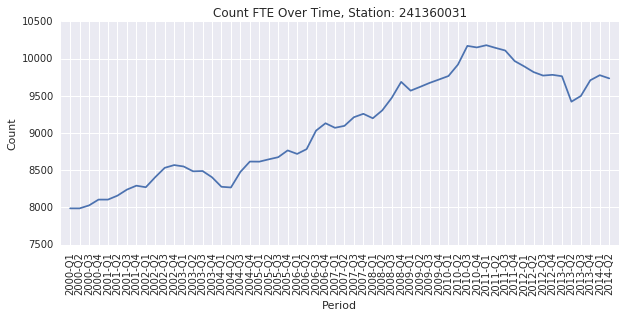

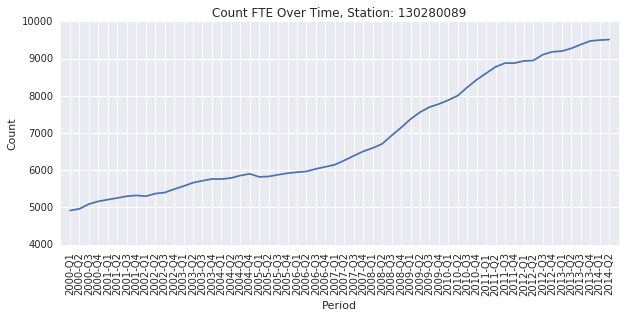

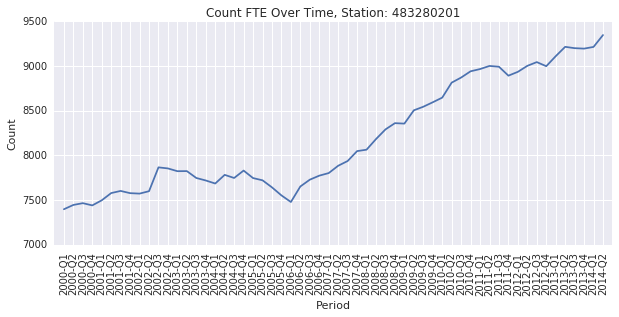

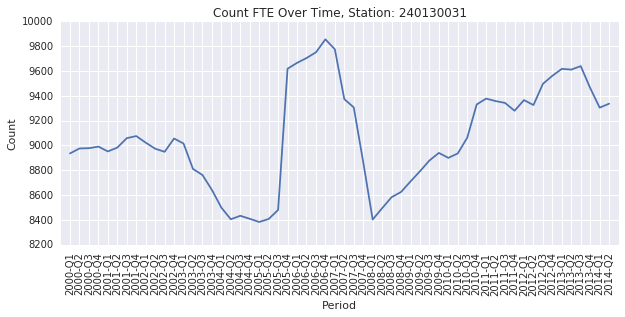

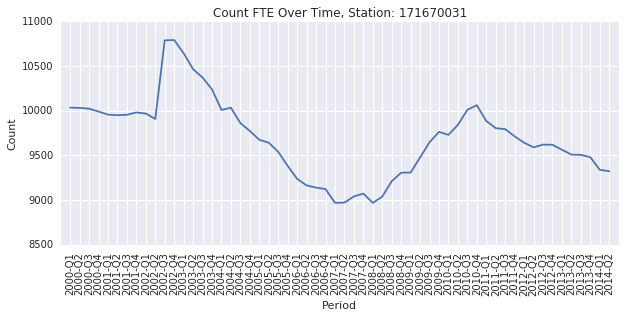

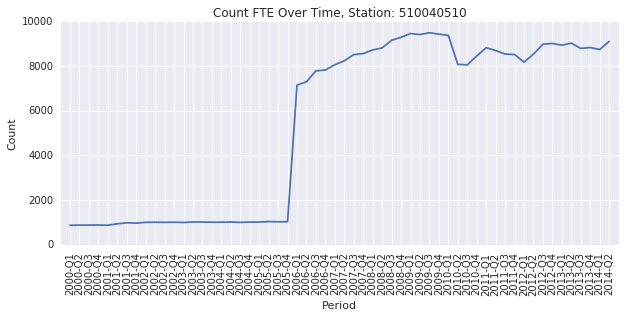

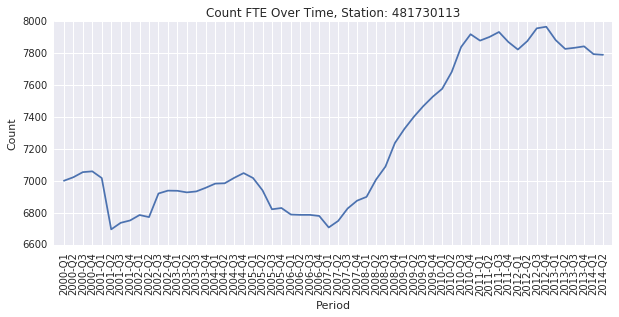

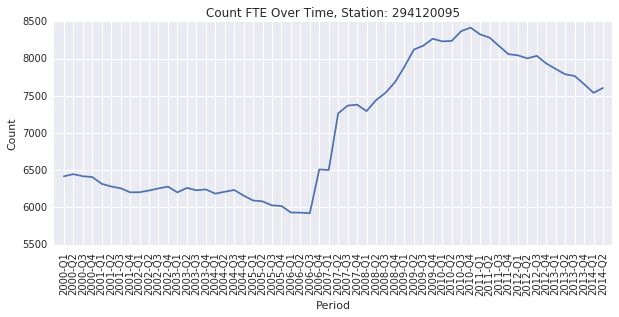

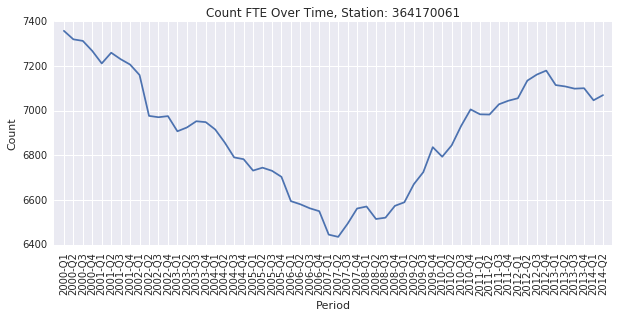

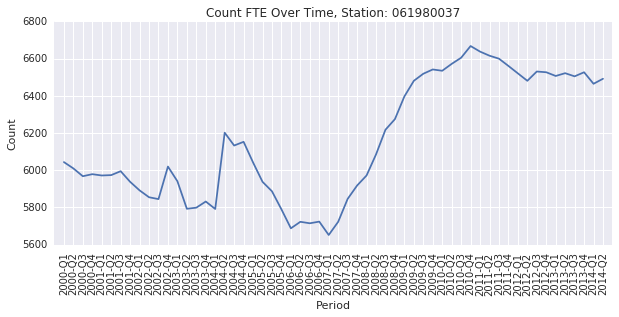

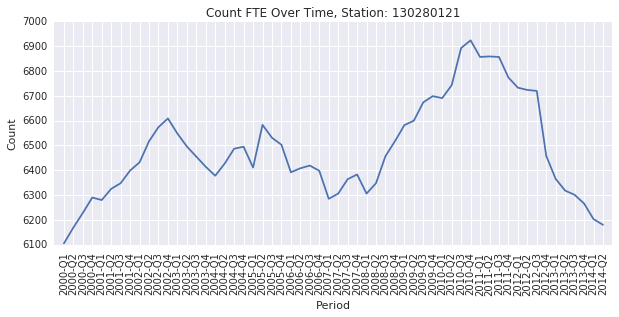

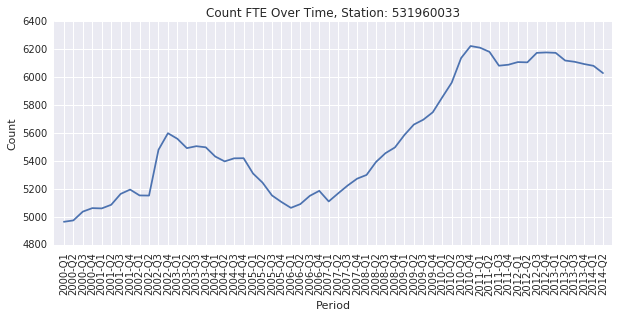

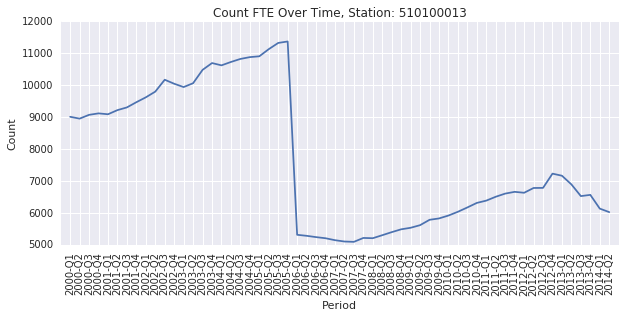

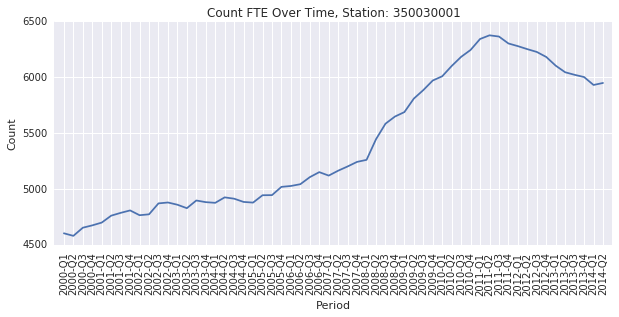

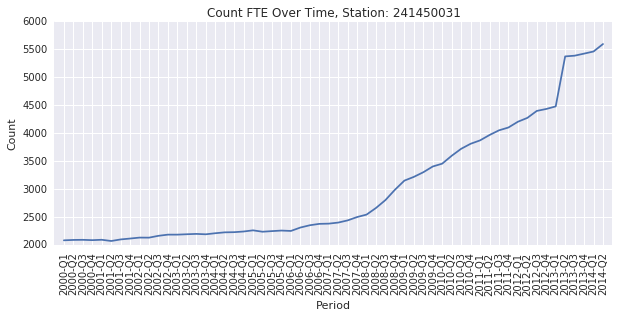

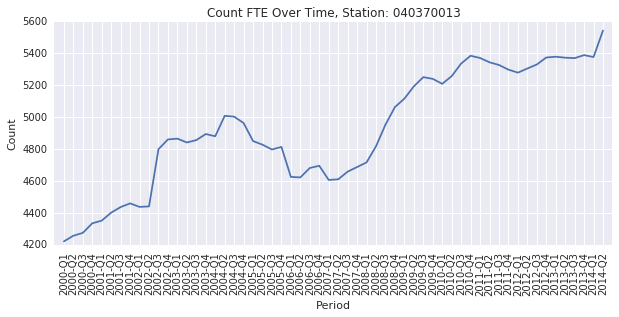

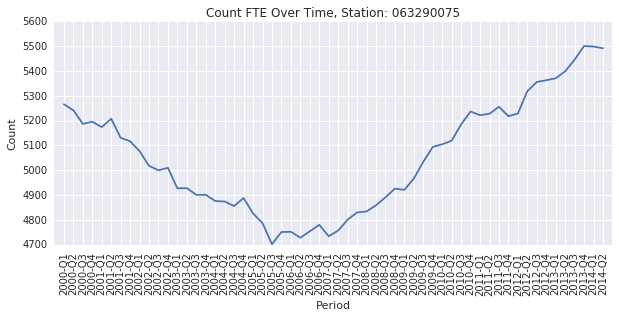

In [249]:
# Count FTE for top 20 stations
# Sample chart (rest will be in Tableau?)

def station_emp_count(df, station):
  count_fte_station = df.loc[df['duty_station'] == station].sort_values('period')
  fig = plt.figure(figsize=(10, 4))
  objects = list(count_fte_station.period)
  y_pos = np.arange(len(count_fte_station))
  countfte = list(count_fte_station.countdistinct)

  plt.plot(countfte)
  plt.xlim((-1, 58))
  plt.xticks(y_pos, objects, rotation = 'vertical')
  plt.ylabel('Count')
  plt.xlabel('Period')
  plt.title('Count FTE Over Time, Station: ' + str(station))
 
  plt.show()

for station in top_stations:
  station_emp_count(station_fte, station)

### Looks like ~6,000 Alexandria folks were moved to Alrtington (20 min drive) in Q1-2006

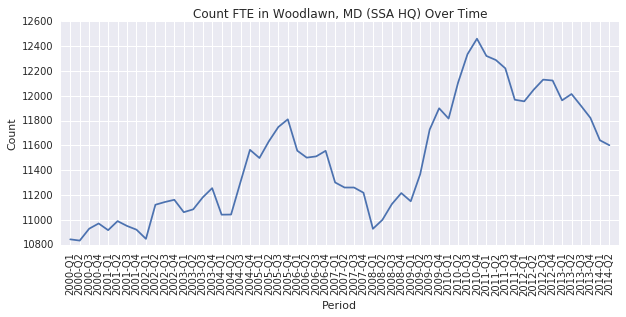

In [195]:
# Count FTE for duty station = 241598005 (Woodlawn, MD, HQ of SSA)
# Sample chart (rest will be in Tableau?)

count_fte_woodlawn = station_fte.loc[station_fte['duty_station'] == '241698005'].sort_values('period')
fig = plt.figure(figsize=(10, 4))
objects = list(count_fte_woodlawn.period)
y_pos = np.arange(len(count_fte_woodlawn))
countfte = list(count_fte_woodlawn.countdistinct)
 
plt.plot(countfte)
plt.xlim((-1, 58))
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.ylabel('Count')
plt.xlabel('Period')
plt.title('Count FTE in Woodlawn, MD (SSA HQ) Over Time')
 
plt.show()

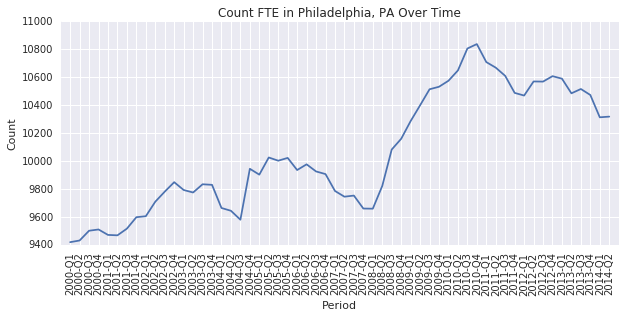

In [198]:
# Count FTE for duty station = 426540101 (Philadelphia)
# Sample chart (rest will be in Tableau?)

count_fte_phil = station_fte.loc[station_fte['duty_station'] == '426540101'].sort_values('period')
fig = plt.figure(figsize=(10, 4))
objects = list(count_fte_phil.period)
y_pos = np.arange(len(count_fte_phil))
countfte = list(count_fte_phil.countdistinct)
 
plt.plot(countfte)
plt.xlim((-1, 58))
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.ylabel('Count')
plt.xlabel('Period')
plt.title('Count FTE in Philadelphia, PA Over Time')
 
plt.show()

# Employee Count by Age

In [207]:
%%bq query
# check for missing ages, e.g. NULL ages
SELECT DISTINCT age 
FROM `processed_data.status`
# No missing age information, e.g. no NULL age

age
55-59
35-39
20-24
75+
UNSP
40-44
45-49
60-64
30-34
50-54


### There is no missing age information

In [204]:
# Count of employees by Age and Period, FTE only

age_all_fte = bq.Query('SELECT FILE_DT as date, age, COUNT(EMP_ID) as countemp, COUNT(DISTINCT EMP_ID) as countdistinct, NSFTP_IND \
                    FROM `processed_data.status` \
                    WHERE NSFTP_IND = "1" \
                    GROUP BY FILE_DT, NSFTP_IND, age \
                    ORDER BY FILE_DT ASC, age')
age_all_fte = age_all_fte.execute(output_options=bq.QueryOutput.dataframe()).result()

# Convert date to datetime format
age_all_fte['date'] = age_all_fte['date'].astype('datetime64[ns]')

# Convert date to quarter (for better graphing)
age_all_fte['year'] = age_all_fte['date'].dt.year
age_all_fte['quarter'] = age_all_fte['date'].dt.quarter
age_all_fte['period'] = age_all_fte['year'].astype(str) +'-Q'+ age_all_fte['quarter'].astype(str)

print age_all_fte.head()
print age_all_fte.dtypes

        date    age  countemp  countdistinct NSFTP_IND  year  quarter   period
0 2000-03-31  15-19      1152           1152         1  2000        1  2000-Q1
1 2000-03-31  20-24     15652          15644         1  2000        1  2000-Q1
2 2000-03-31  25-29     61135          61068         1  2000        1  2000-Q1
3 2000-03-31  30-34    128492         128353         1  2000        1  2000-Q1
4 2000-03-31  35-39    198680         198469         1  2000        1  2000-Q1
date             datetime64[ns]
age                      object
countemp                  int64
countdistinct             int64
NSFTP_IND                object
year                      int64
quarter                   int64
period                   object
dtype: object


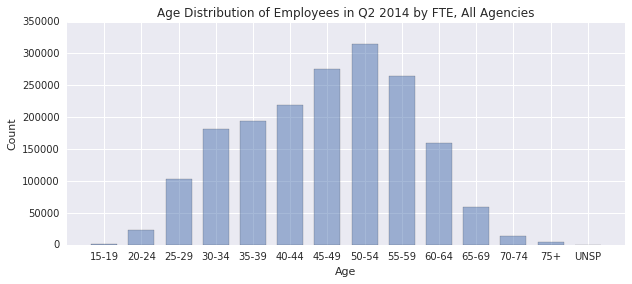

['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+', 'UNSP']


In [217]:
# Distribution of Age of All unique FTE employees as of Q2-2014
age_all = age_all_fte.loc[age_all_fte['period'] == '2014-Q2'].sort_values('age')

fig = plt.figure(figsize=(10, 4))
objects = list(age_all.age)
y_pos = np.arange(len(age_all))
countfte = list(age_all.countdistinct)
 
plt.bar(y_pos, countfte, alpha=0.5, width=0.7, align="center")
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.xlabel('Age')
plt.xlim((-1, 14))
plt.title('Age Distribution of Employees in Q2 2014 by FTE, All Agencies')
 
plt.show()
print objects

# Employee Count by Age and Agency

In [200]:
# Count of employees by Age, Agency and Period, FTE only

age_agency_fte = bq.Query('SELECT FILE_DT as date, agency, age, COUNT(EMP_ID) as countemp, COUNT(DISTINCT EMP_ID) as countdistinct, NSFTP_IND \
                    FROM `processed_data.status` \
                    WHERE NSFTP_IND = "1" \
                    GROUP BY FILE_DT, NSFTP_IND, agency, age \
                    ORDER BY FILE_DT ASC, agency, age')
age_agency_fte = age_agency_fte.execute(output_options=bq.QueryOutput.dataframe()).result()

# Convert date to datetime format
age_agency_fte['date'] = age_agency_fte['date'].astype('datetime64[ns]')

# Convert date to quarter (for better graphing)
age_agency_fte['year'] = age_agency_fte['date'].dt.year
age_agency_fte['quarter'] = age_agency_fte['date'].dt.quarter
age_agency_fte['period'] = age_agency_fte['year'].astype(str) +'-Q'+ age_agency_fte['quarter'].astype(str)

print age_agency_fte.head()
print age_agency_fte.dtypes

        date agency    age  countemp  countdistinct NSFTP_IND  year  quarter  \
0 2000-03-31   AB00  30-34         1              1         1  2000        1   
1 2000-03-31   AB00  35-39         2              2         1  2000        1   
2 2000-03-31   AB00  40-44         1              1         1  2000        1   
3 2000-03-31   AB00  45-49         1              1         1  2000        1   
4 2000-03-31   AB00  50-54         4              4         1  2000        1   

    period  
0  2000-Q1  
1  2000-Q1  
2  2000-Q1  
3  2000-Q1  
4  2000-Q1  
date             datetime64[ns]
agency                   object
age                      object
countemp                  int64
countdistinct             int64
NSFTP_IND                object
year                      int64
quarter                   int64
period                   object
dtype: object


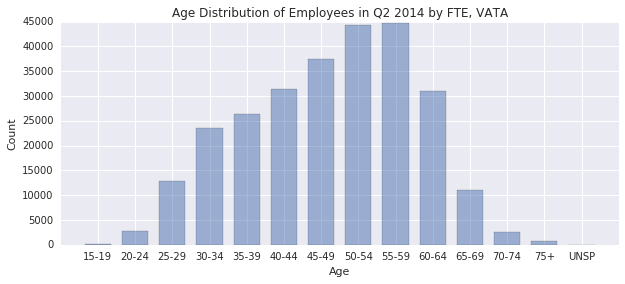

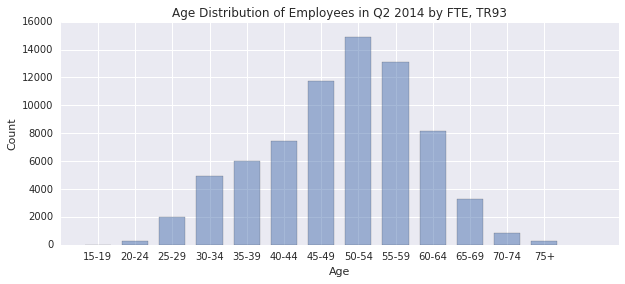

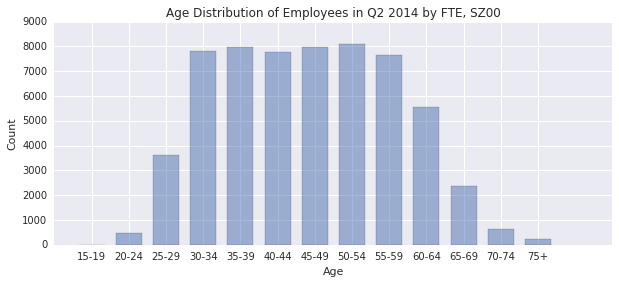

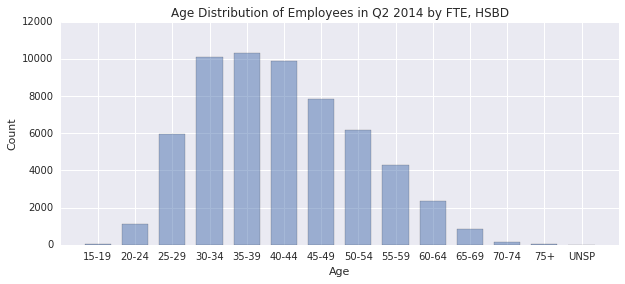

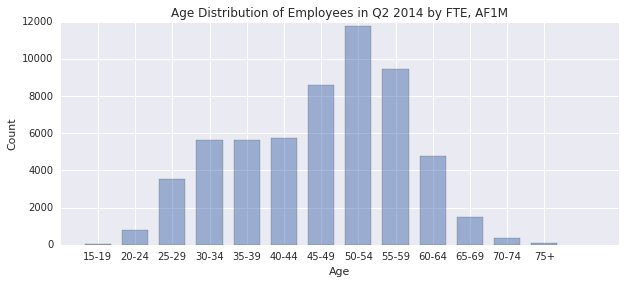

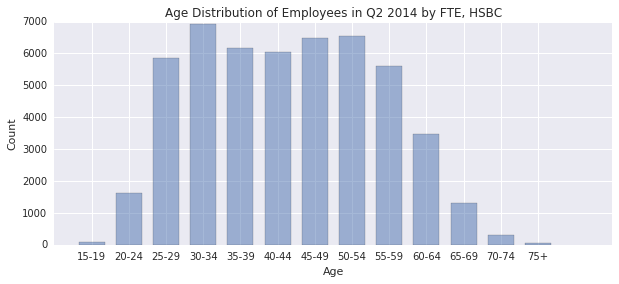

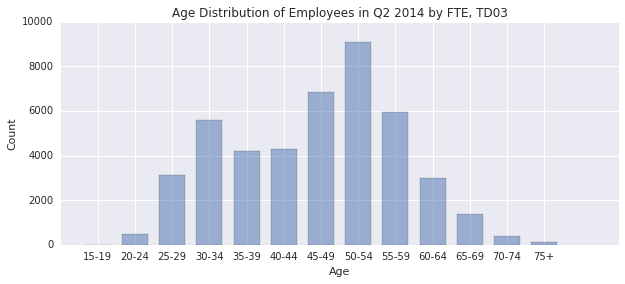

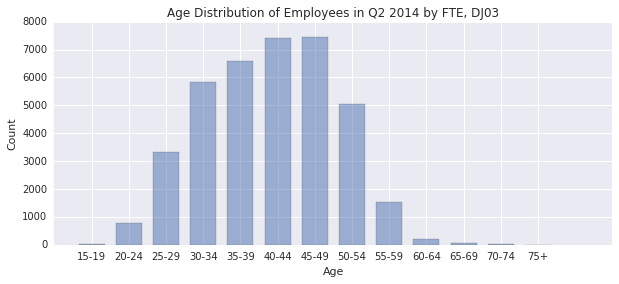

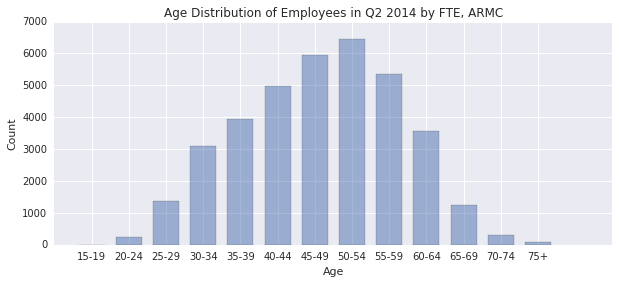

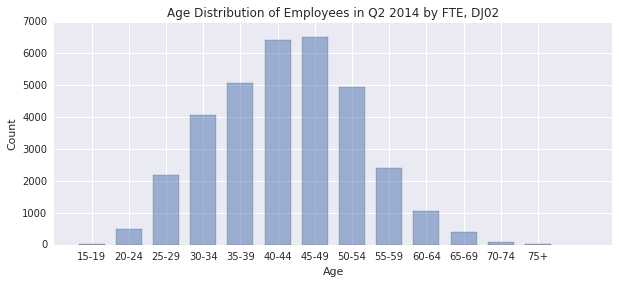

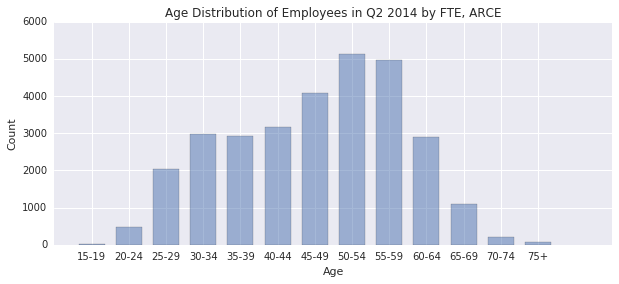

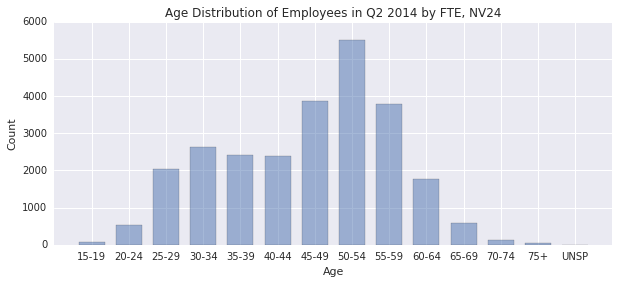

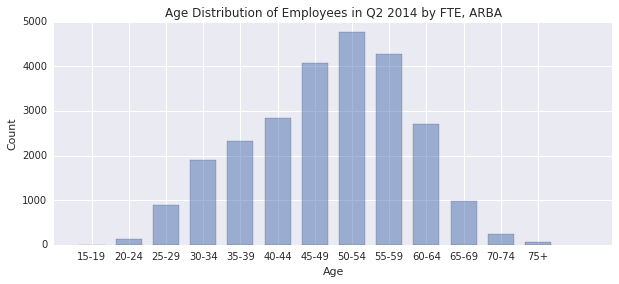

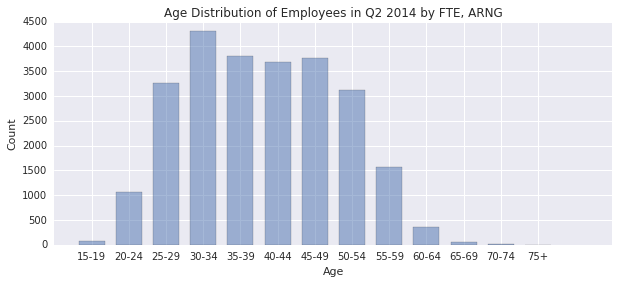

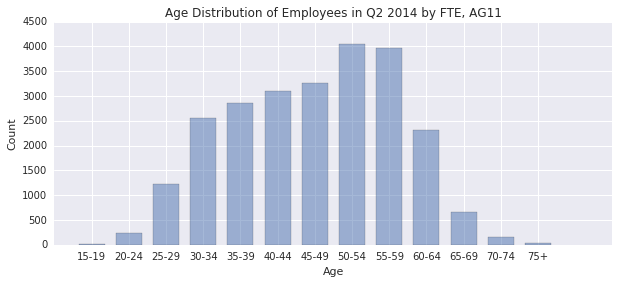

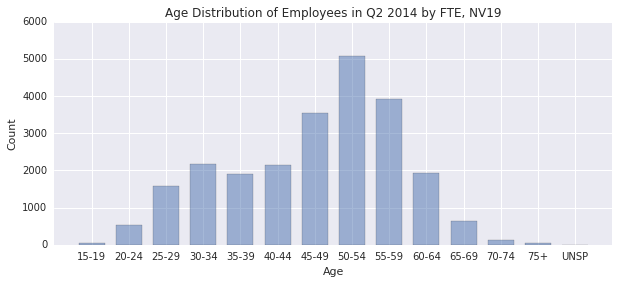

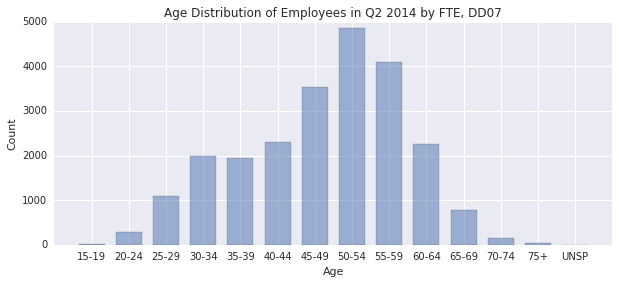

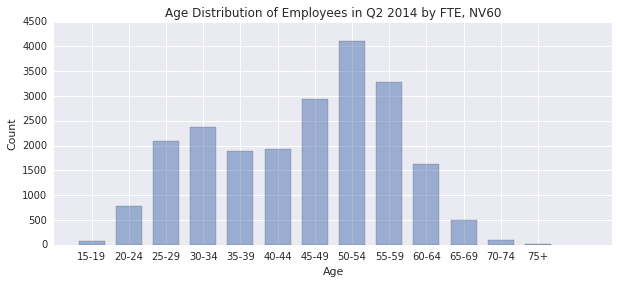

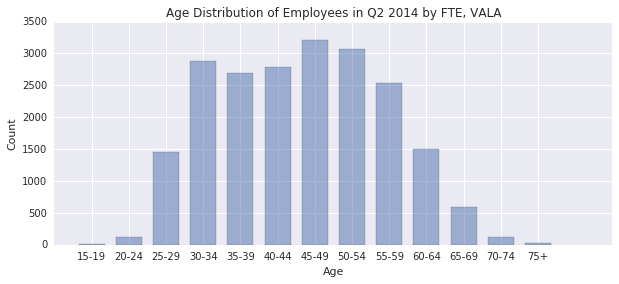

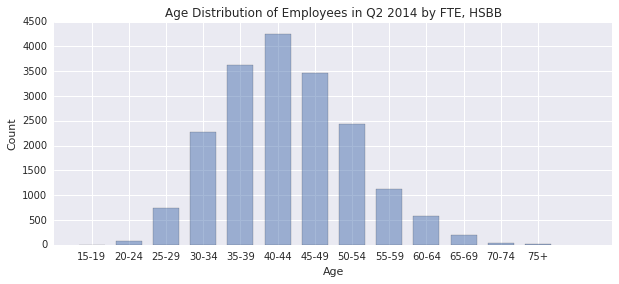

In [245]:
def plot_age_hist(df, agency, period):
  age_agency = df.loc[df['period'] == '2014-Q2'].loc[df['agency'] == agency].sort_values('age')

  fig = plt.figure(figsize=(10, 4))
  objects = list(age_agency.age)
  y_pos = np.arange(len(age_agency))
  countfte = list(age_agency.countdistinct)

  plt.bar(y_pos, countfte, alpha=0.5, width=0.7, align="center")
  plt.xticks(y_pos, objects)
  plt.ylabel('Count')
  plt.xlabel('Age')
  plt.xlim((-1, 14))
  plt.title('Age Distribution of Employees in Q2 2014 by FTE, ' + str(agency))
  plt.show()
  
for agency in top_agencies:
  plot_age_hist(age_agency_fte, agency , '2014-Q2')

In [266]:
%%bq query
# Why might some employees have multiple rows? Change in agency, error, etc.?
# Find employees with multiple rows in Q2 2014 (using latest quarter as example)

WITH Q42014 AS (
  SELECT CAST(FILE_DT AS string) AS date, EMP_ID
  FROM `processed_data.status` 
  WHERE CAST(FILE_DT AS string) = '2014-06-30'
)
SELECT EMP_ID, COUNT(EMP_ID) as countemp
FROM Q42014
GROUP BY EMP_ID
HAVING ( COUNT(EMP_ID) > 1 )
ORDER BY countemp DESC

EMP_ID,countemp
008319571,5
008599029,4
009820361,4
004308409,3
003564988,3
010256397,3
000776851,3
007917068,3
003418404,3
005652588,3


# Education Levels

In [250]:
%%bq query
# check for missing education levels, e.g. NULL ages
SELECT DISTINCT education_level 
FROM `processed_data.status`
# No missing education information, e.g. no NULL age

education_level
04
10
06
16
20
03
""
01
11
18


### There is no missing education information (no NULL, missing or NA represented as '**')

In [253]:
# Count of employees by education levels and Period, FTE only

edu_all_fte = bq.Query('SELECT FILE_DT as date, education_level, COUNT(EMP_ID) as countemp, COUNT(DISTINCT EMP_ID) as countdistinct, NSFTP_IND \
                    FROM `processed_data.status` \
                    WHERE NSFTP_IND = "1" \
                    GROUP BY FILE_DT, NSFTP_IND, education_level \
                    ORDER BY FILE_DT ASC, education_level')
edu_all_fte = edu_all_fte.execute(output_options=bq.QueryOutput.dataframe()).result()

# Convert date to datetime format
edu_all_fte['date'] = edu_all_fte['date'].astype('datetime64[ns]')

# Convert date to quarter (for better graphing)
edu_all_fte['year'] = edu_all_fte['date'].dt.year
edu_all_fte['quarter'] = edu_all_fte['date'].dt.quarter
edu_all_fte['period'] = edu_all_fte['year'].astype(str) +'-Q'+ edu_all_fte['quarter'].astype(str)

print edu_all_fte.head()
print edu_all_fte.dtypes

        date education_level  countemp  countdistinct NSFTP_IND  year  \
0 2000-03-31              **     19879          19879         1  2000   
1 2000-03-31              01      1115           1115         1  2000   
2 2000-03-31              02      1320           1320         1  2000   
3 2000-03-31              03     18845          18841         1  2000   
4 2000-03-31              04    398115         397575         1  2000   

   quarter   period  
0        1  2000-Q1  
1        1  2000-Q1  
2        1  2000-Q1  
3        1  2000-Q1  
4        1  2000-Q1  
date               datetime64[ns]
education_level            object
countemp                    int64
countdistinct               int64
NSFTP_IND                  object
year                        int64
quarter                     int64
period                     object
dtype: object


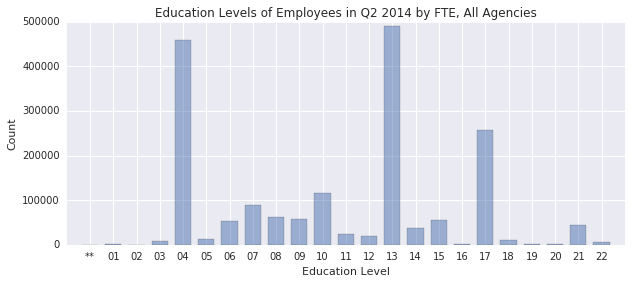

[259, 686, 350, 8600, 458205, 13550, 54376, 89734, 63189, 58698, 116156, 24853, 19151, 489361, 38130, 56386, 2255, 256523, 11494, 1002, 707, 44925, 6642]


In [263]:
# Distribution of Education of All unique FTE employees as of Q2-2014
edu_all = edu_all_fte.loc[edu_all_fte['period'] == '2014-Q2'].sort_values('education_level')

fig = plt.figure(figsize=(10, 4))
objects = list(edu_all.education_level)
y_pos = np.arange(len(edu_all))
countfte = list(edu_all.countdistinct)
 
plt.bar(y_pos, countfte, alpha=0.5, width=0.7, align="center")
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.xlabel('Education Level')
plt.xlim((-1, 23))
plt.title('Education Levels of Employees in Q2 2014 by FTE, All Agencies')
 
plt.show()
print countfte

## Education Levels by Agency

In [260]:
# Count of employees by Education, Agency and Period, FTE only

edu_agency_fte = bq.Query('SELECT FILE_DT as date, agency, education_level, COUNT(EMP_ID) as countemp, COUNT(DISTINCT EMP_ID) as countdistinct, NSFTP_IND \
                    FROM `processed_data.status` \
                    WHERE NSFTP_IND = "1" \
                    GROUP BY FILE_DT, NSFTP_IND, agency, education_level \
                    ORDER BY FILE_DT ASC, agency, education_level')
edu_agency_fte = edu_agency_fte.execute(output_options=bq.QueryOutput.dataframe()).result()

# Convert date to datetime format
edu_agency_fte['date'] = edu_agency_fte['date'].astype('datetime64[ns]')

# Convert date to quarter (for better graphing)
edu_agency_fte['year'] = edu_agency_fte['date'].dt.year
edu_agency_fte['quarter'] = edu_agency_fte['date'].dt.quarter
edu_agency_fte['period'] = edu_agency_fte['year'].astype(str) +'-Q'+ edu_agency_fte['quarter'].astype(str)

print edu_agency_fte.head()
print edu_agency_fte.dtypes

        date agency education_level  countemp  countdistinct NSFTP_IND  year  \
0 2000-03-31   AB00              **         1              1         1  2000   
1 2000-03-31   AB00              04         8              8         1  2000   
2 2000-03-31   AB00              06         2              2         1  2000   
3 2000-03-31   AB00              07         1              1         1  2000   
4 2000-03-31   AB00              08         3              3         1  2000   

   quarter   period  
0        1  2000-Q1  
1        1  2000-Q1  
2        1  2000-Q1  
3        1  2000-Q1  
4        1  2000-Q1  
date               datetime64[ns]
agency                     object
education_level            object
countemp                    int64
countdistinct               int64
NSFTP_IND                  object
year                        int64
quarter                     int64
period                     object
dtype: object


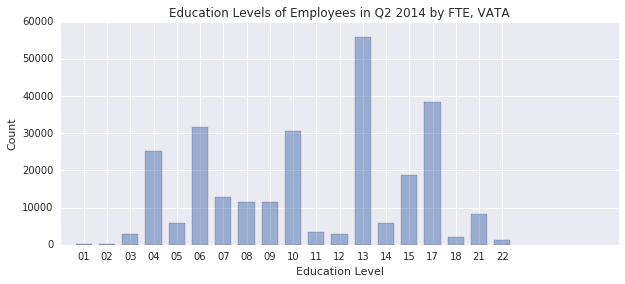

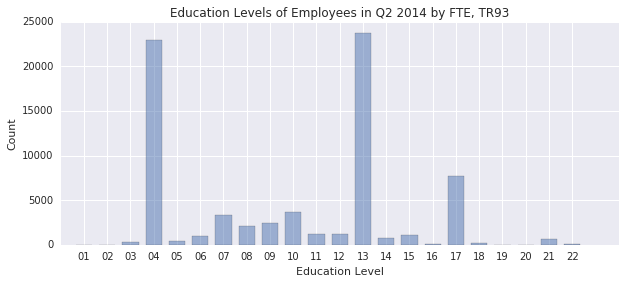

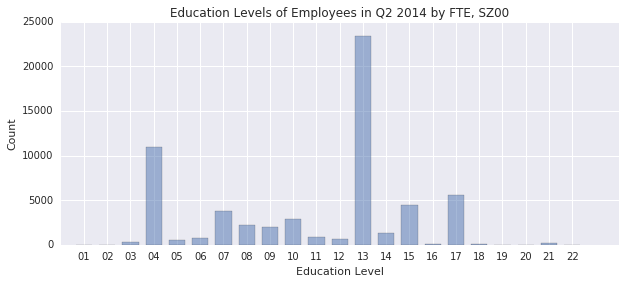

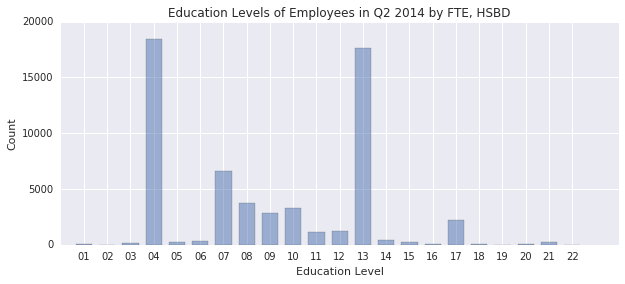

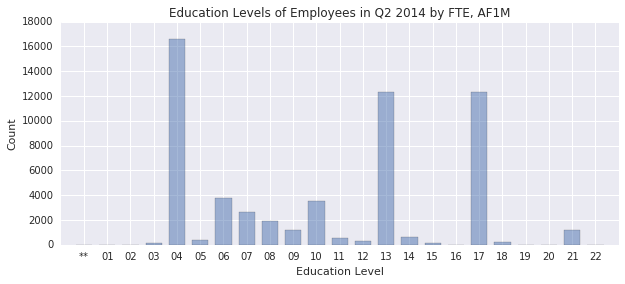

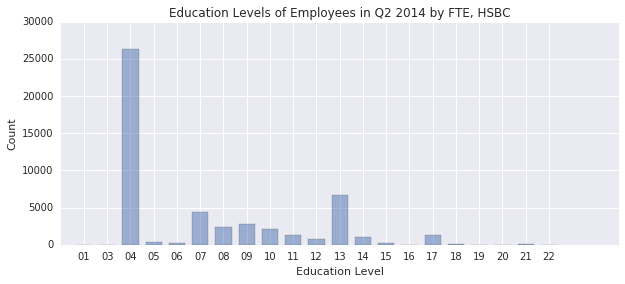

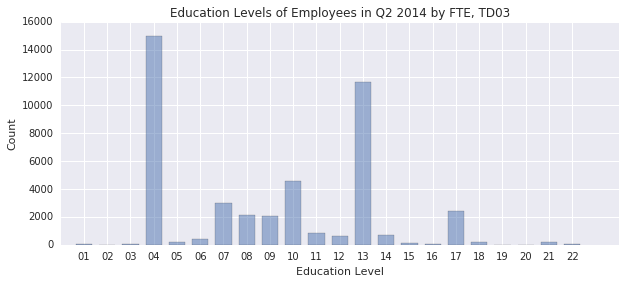

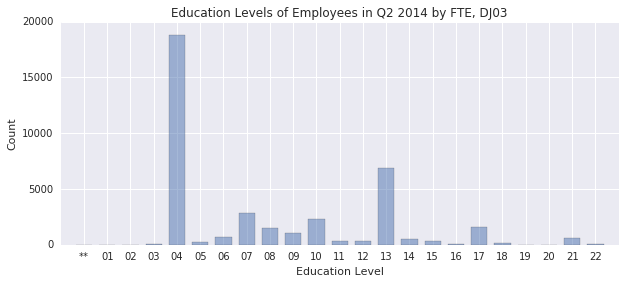

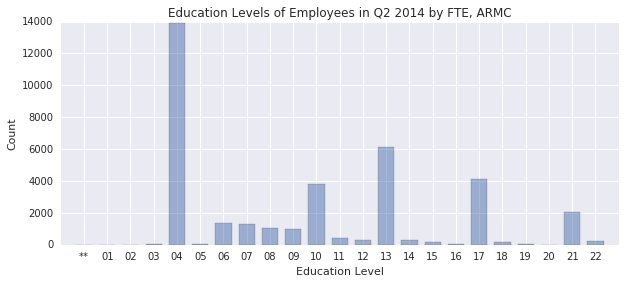

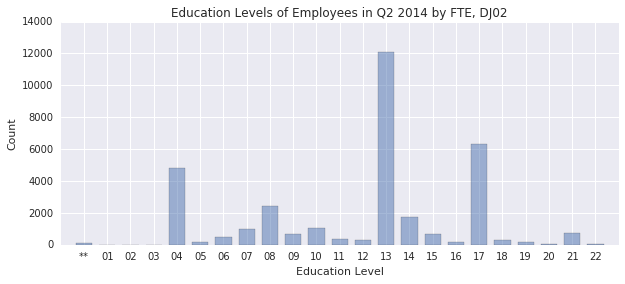

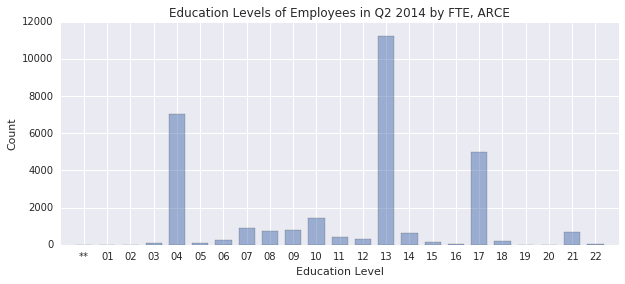

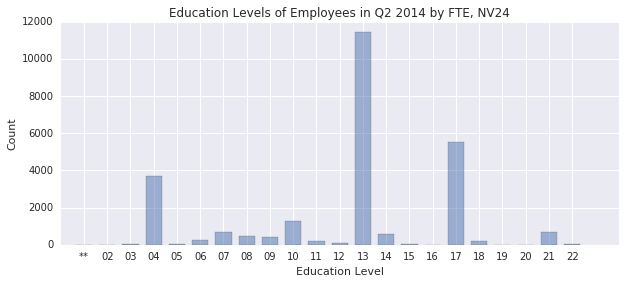

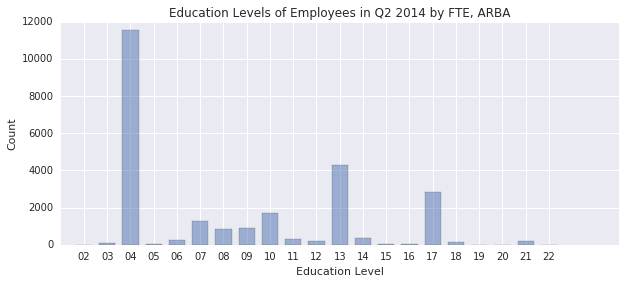

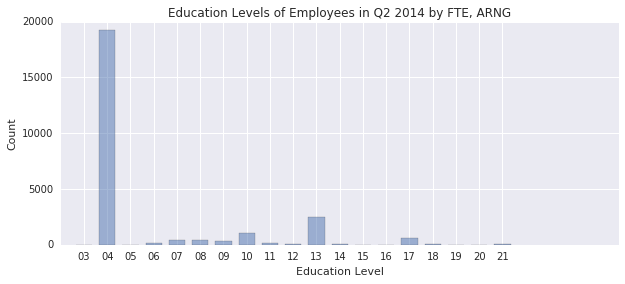

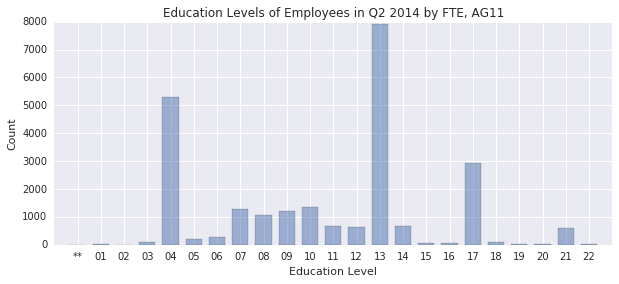

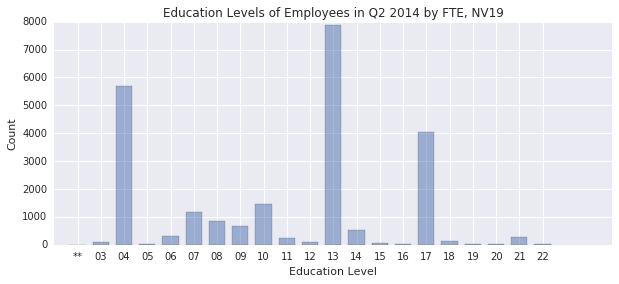

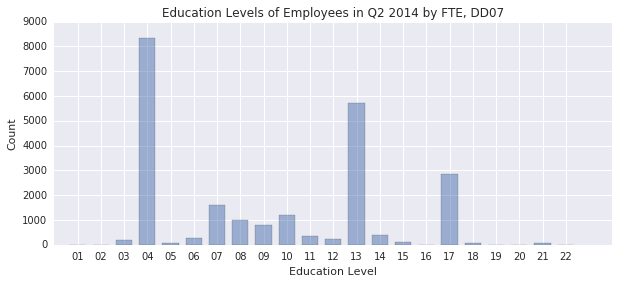

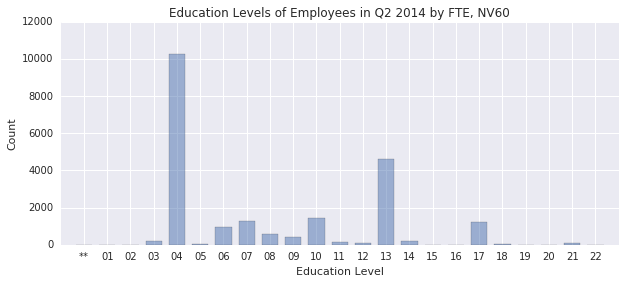

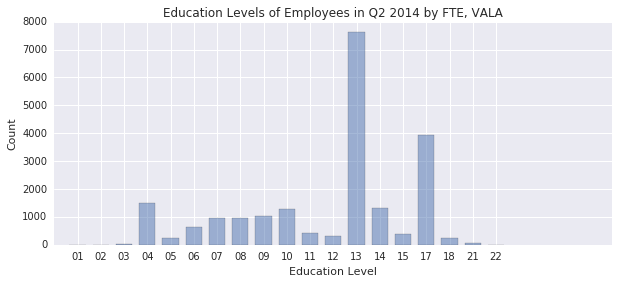

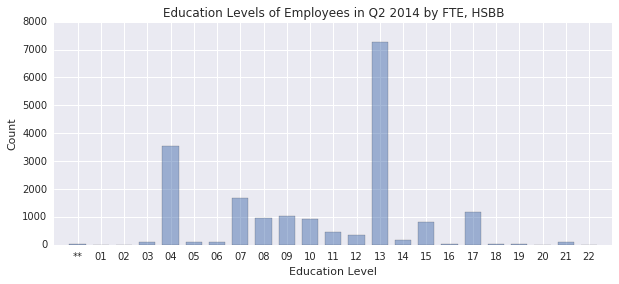

In [266]:
def plot_edu_hist(df, agency, period):
  edu_agency = df.loc[df['period'] == period].loc[df['agency'] == agency].sort_values('education_level')

  fig = plt.figure(figsize=(10, 4))
  objects = list(edu_agency.education_level)
  y_pos = np.arange(len(edu_agency))
  countfte = list(edu_agency.countdistinct)

  plt.bar(y_pos, countfte, alpha=0.5, width=0.7, align="center")
  plt.xticks(y_pos, objects)
  plt.ylabel('Count')
  plt.xlabel('Education Level')
  plt.xlim((-1, 23))
  plt.title('Education Levels of Employees in Q2 2014 by FTE, ' + str(agency))
  plt.show()
  
for agency in top_agencies:
  plot_edu_hist(edu_agency_fte, agency , '2014-Q2')

# Pay Grade

In [271]:
%%bq query
# check for missing pay plan, e.g. NULL pay plans
SELECT DISTINCT pay_plan 
FROM `processed_data.status`
ORDER BY pay_plan
# No missing pay plan information, e.g. no NULL pay plans

pay_plan
**
AA
AD
AF
AI
AJ
AL
AO
AP
AS


## There are 227 Pay Plans (two-character alpha code)!

# GRADE

In [272]:
%%bq query
# check for missing pay grades , e.g. NULL pay grades
SELECT DISTINCT grade 
FROM `processed_data.status`
ORDER BY grade
# No missing education information, e.g. no NULL age

grade
""
**
0
00
01
02
03
04
05
06


## There are 198 grades, and some null grade information

# Exploring Duplicate Employee Rows per Quarter

### Individuals may have duplicate rows per quarter if they are working in multiple agencies at once or in transition. There does not appear to be too many of these cases.

In [308]:
%%bq query

# Why might some employees have multiple rows? Change in agency, error, etc.?
# Look at employees with multiple obs in each quarter

SELECT file_dt as date, nsftp_ind, emp_id, COUNT(emp_id) as countemp
FROM `processed_data.status`
WHERE nsftp_ind = '1'
GROUP BY emp_id, file_dt, nsftp_ind
ORDER BY countemp DESC, emp_id ASC
LIMIT 150


date,nsftp_ind,emp_id,countemp
2002-06-30,1,006165929,25
2004-06-30,1,008970301,4
2004-03-31,1,008970301,4
2012-12-13,1,000016707,3
2014-03-31,1,000022140,3
2012-09-30,1,000035094,3
2008-12-13,1,000051174,3
2002-12-13,1,000085298,3
2002-06-30,1,000138693,3
2007-12-13,1,000188964,3


In [316]:
%%bq query

SELECT *
FROM `processed_data.status` 
WHERE nsftp_ind = '1'
AND EMP_ID = '001931406'
AND file_dt = '2008-09-30'


emp_id,file_dt,agency,duty_station,age,education_level,pay_plan,grade,los,occupation,occupation_cat,basic_pay,superv_status,type_appoint,work_schedule,nsftp_ind,dod,year_file_dt,month_file_dt,day_file_dt,quarter_file_dt,week_file_dt
001931406,2008-09-30,ARX7,#########,45-49,04,GS,09,25-29,2001,T,63577,6,10,F,1,1,2008,9,30,3,39
001931406,2008-09-30,DD63,#########,45-49,13,GS,11,25-29,1102,P,63577,8,10,F,1,1,2008,9,30,3,39
001931406,2008-09-30,HSBB,#########,40-44,13,GS,09,25-29,0301,A,58557,8,10,F,1,0,2008,9,30,3,39


In [314]:
%%bq query

SELECT *
FROM `processed_data.status` 
WHERE EMP_ID = '001931406'
ORDER BY file_dt DESC


emp_id,file_dt,agency,duty_station,age,education_level,pay_plan,grade,los,occupation,occupation_cat,basic_pay,superv_status,type_appoint,work_schedule,nsftp_ind,dod,year_file_dt,month_file_dt,day_file_dt,quarter_file_dt,week_file_dt
001931406,2014-06-30,VATA,#########,45-49,13,GS,12,30-34,1102,P,78762,8,10,F,1,0,2014,6,30,2,26
001931406,2014-03-31,VATA,#########,45-49,13,GS,12,30-34,1102,P,78762,8,10,F,1,0,2014,3,31,1,13
001931406,2013-12-13,VATA,#########,50-54,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2013,12,13,4,49
001931406,2013-09-30,VATA,#########,50-54,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2013,9,30,3,39
001931406,2013-06-30,VATA,#########,50-54,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2013,6,30,2,26
001931406,2013-03-31,VATA,#########,50-54,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2013,3,31,1,13
001931406,2012-12-13,VATA,#########,45-49,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2012,12,13,4,50
001931406,2012-09-30,VATA,#########,45-49,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2012,9,30,3,40
001931406,2012-06-30,VATA,#########,45-49,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2012,6,30,2,26
001931406,2012-03-31,VATA,#########,45-49,13,GS,12,30-34,1102,P,75689,8,10,F,1,0,2012,3,31,1,13


In [315]:
%%bq query

SELECT *
FROM `processed_data.dynamic` 
WHERE EMP_ID = '001931406'
ORDER BY effective_dt



emp_id,agency,acces_sep_ind,effective_dt,age,pay_plan,grade,los,duty_station,occupation,occupation_cat,basic_pay,type_appoint,work_schedule,dod_ind,year_eff_dt,month_eff_dt,day_eff_dt,quarter_eff_dt,week_eff_dt
001931406,DD07,SH,2008-03-28,45-49,GS,11,25-29,#########,1101,A,63577,10,F,1,2008,3,28,1,12
001931406,ARX7,AC,2008-04-28,40-44,GS,09,25-29,#########,2001,T,63577,10,F,1,2008,4,28,2,17
001931406,DD63,SA,2008-08-30,40-44,GS,**,25-29,#########,2001,*,,10,F,1,2008,8,30,3,34
001931406,HSBB,AA,2008-08-31,45-49,GS,09,25-29,#########,0301,A,58557,10,F,0,2008,8,31,3,35
001931406,ARX7,AA,2008-09-28,45-49,GS,09,25-29,#########,2001,T,63577,10,F,1,2008,9,28,3,39
001931406,HSBB,SA,2008-09-28,45-49,GS,09,25-29,#########,0301,A,58557,10,F,0,2008,9,28,3,39
001931406,DD63,SA,2011-01-15,50-54,GS,11,25-29,#########,1102,P,68888,10,F,1,2011,1,15,1,2
001931406,VATA,AA,2011-01-16,45-49,GS,12,25-29,#########,1102,P,73396,10,F,0,2011,1,16,1,3


In [6]:
%%bq query
# Deep-dive into employee 004534805 who has 2 obs in Q2-2014, because of agency change

SELECT *
FROM `processed_data.status` 
WHERE EMP_ID = '004534805'
ORDER BY FILE_DT DESC

emp_id,file_dt,agency,duty_station,age,education_level,pay_plan,grade,los,occupation,occupation_cat,basic_pay,superv_status,type_appoint,work_schedule,nsftp_ind,dod,year_file_dt,month_file_dt,day_file_dt,quarter_file_dt,week_file_dt
004534805,2014-06-30,HSAC,#########,35-39,13,GS,14,5-9,1102,P,109804,8,15,F,1,0,2014,6,30,2,26
004534805,2014-06-30,NV19,#########,30-34,13,GS,13,5-9,1102,P,101914,8,10,F,1,1,2014,6,30,2,26
004534805,2014-03-31,NV19,#########,30-34,13,GS,13,5-9,1102,P,101914,8,10,F,1,1,2014,3,31,1,13
004534805,2013-12-13,NV19,#########,35-39,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2013,12,13,4,49
004534805,2013-09-30,NV19,#########,30-34,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2013,9,30,3,39
004534805,2013-06-30,NV19,#########,30-34,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2013,6,30,2,26
004534805,2013-03-31,NV19,#########,30-34,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2013,3,31,1,13
004534805,2012-12-13,NV19,#########,35-39,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2012,12,13,4,50
004534805,2012-09-30,NV19,#########,30-34,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2012,9,30,3,40
004534805,2012-06-30,NV19,#########,30-34,13,GS,13,5-9,1102,P,97936,8,10,F,1,1,2012,6,30,2,26


In [276]:
%%bq query
# Deep-dive into employee 004534805 who has 2 obs in Q2-2014, because of agency change

SELECT *
FROM `processed_data.dynamic` 
WHERE EMP_ID = '004534805'

emp_id,agency,acces_sep_ind,effective_dt,age,pay_plan,grade,los,duty_station,occupation,occupation_cat,basic_pay,type_appoint,work_schedule,dod_ind,year_eff_dt,month_eff_dt,day_eff_dt,quarter_eff_dt,week_eff_dt
004534805,HSAC,AC,2014-05-18,35-39,GS,14,5-9,#########,1102,P,109804,15,F,0,2014,5,18,2,20
004534805,NV19,SA,2014-05-17,35-39,GS,13,5-9,#########,1102,P,101914,10,F,1,2014,5,17,2,19
004534805,NV76,AD,2005-03-21,25-29,GS,07,UNSP,#########,1102,P,35452,32,F,1,2005,3,21,1,12


In [296]:
%%bq query
# Count of observations by employee

SELECT emp_id, COUNT(emp_id) as countemp
FROM `processed_data.status`
GROUP BY emp_id
ORDER BY countemp DESC
LIMIT 10

emp_id,countemp
004101442,161
003557566,143
008108528,138
008334965,137
004204523,134
001244633,131
004023994,129
000506655,126
009303091,125
007802862,125


In [12]:
%%bq query
# Do the same deep-dive into employee 003557566

SELECT AGENCY, COUNT(AGENCY) AS countagency
FROM `processed_data.status` 
WHERE EMP_ID = '003557566'
GROUP BY AGENCY

AGENCY,countagency
HE35,17
HE39,66
ARMC,2
EP00,58


In [17]:
%%bq query
# This person's LOS is all over, maybe because seasonal

SELECT *
FROM `processed_data.status` 
WHERE EMP_ID = '003557566'
AND AGENCY = 'HE39'
AND OCCUPATION = '0601'
ORDER BY FILE_DT DESC

emp_id,file_dt,agency,duty_station,age,education_level,pay_plan,grade,los,occupation,occupation_cat,basic_pay,superv_status,type_appoint,work_schedule,nsftp_ind,dod,year_file_dt,month_file_dt,day_file_dt,quarter_file_dt,week_file_dt
003557566,2014-06-30,HE39,#########,65-69,15,EI,00,< 1,0601,P,65219,8,48,I,2,0,2014,6,30,2,26
003557566,2013-09-30,HE39,#########,60-64,15,EI,00,< 1,0601,P,65219,8,48,I,2,0,2013,9,30,3,39
003557566,2013-06-30,HE39,#########,65-69,15,EI,00,< 1,0601,P,65219,8,48,I,2,0,2013,6,30,2,26
003557566,2013-03-31,HE39,#########,65-69,15,EI,00,< 1,0601,P,65219,8,48,I,2,0,2013,3,31,1,13
003557566,2012-12-13,HE39,#########,65-69,15,EI,00,< 1,0601,P,65219,8,48,I,2,0,2012,12,13,4,50
003557566,2012-09-30,HE39,#########,65-69,15,EI,00,1-2,0601,P,65219,8,48,I,2,0,2012,9,30,3,40
003557566,2012-06-30,HE39,#########,60-64,15,EI,00,1-2,0601,P,65219,8,48,I,2,0,2012,6,30,2,26
003557566,2012-03-31,HE39,#########,65-69,15,EI,00,1-2,0601,P,65219,8,48,I,2,0,2012,3,31,1,13
003557566,2011-12-13,HE39,#########,60-64,15,EI,00,1-2,0601,P,65219,8,48,I,2,0,2011,12,13,4,50
003557566,2011-09-30,HE39,#########,65-69,15,EI,00,1-2,0601,P,65219,8,48,I,2,0,2011,9,30,3,39


In [314]:
%%bq query
# Do the same deep-dive into employee 004101442

SELECT nsftp_ind, count(nsftp_ind) as count
FROM `processed_data.status` 
GROUP BY nsftp_ind

nsftp_ind,count
2,14548158
1,95749245


In [158]:
# Total number of agencies
print 'Number of agencies =', len(count_emp.agency.unique())
# What is largest agency in 2014 Q2? 
count_emp_2014_Q2 = count_emp.loc[count_emp['period'] == '2014-Q2'].sort_values('countemp', ascending=False)

objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.bar(list(count_emp_2014_Q2.agency), list(count_emp_2014_Q2.countemp), align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

Number of agencies = 679
